In [1]:
!pip show captum

Name: captum
Version: 0.7.0
Summary: Model interpretability for PyTorch
Home-page: https://captum.ai
Author: PyTorch Team
Author-email: 
License: BSD-3
Location: /Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages
Requires: matplotlib, numpy, torch, tqdm
Required-by: 


In [2]:
# https://arxiv.org/abs/2312.05491
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
from captum.attr import ShapleyValueSampling, LLMAttribution, TextTemplateInput

In [3]:
## Override font to fix korean display issues
from matplotlib import font_manager, rc
font_path = "/Users/id4thomas/fonts/nanum-gothic/NanumGothic.ttf"
font_manager.fontManager.addfont(font_path)
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [4]:
## Load Model & Tokenizer
model_name = "EleutherAI/polyglot-ko-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
  

In [5]:
device = "cpu"
model.to(device)
print("Loaded model on", model.device)

Loaded model on cpu


In [6]:
## Use shapley values attribution method
# supported methods: FeatureAblation, ShapleyValueSampling, ShapleyValues, Lime, and KernelShap
# Lime and KernelShap do not support per-token attribution

# ShapleyValueSampling: 
shapley_values = ShapleyValueSampling(model)

In [7]:
# https://captum.ai/api/llm_attr.html
llm_attr = LLMAttribution(shapley_values, tokenizer)

# Attribution with Baselines & Targets

In [8]:
"""
attribute 계산에 target을 스트링으로 주는 경우
else:
            assert gen_args is None, "gen_args must be None when target is given"

            if type(target) is str:
                # exclude sos
                target_tokens = self.tokenizer.encode(target)[1:]
                target_tokens = torch.tensor(target_tokens)
            elif type(target) is torch.Tensor:
                target_tokens = target
[1: ] 처리를 해버려서 깨지는 것 같다
"""

def calculate_attributions(
		attribution_fn, tokenizer, 
		template, values, 
		baselines = None, 
		target = None
	):
	inp = TextTemplateInput(
		template,
		values = values,
		baselines = baselines
	)
	if target:
		input_ids = tokenizer(target, return_tensors="pt")["input_ids"][0]
		res = attribution_fn.attribute(inp, target = input_ids)
		output_tokens = [tokenizer.decode(id) for id in input_ids]
		## Overwrite output tokens
		res.output_tokens = output_tokens
	else:
		res = attribution_fn.attribute(inp)
	return res

In [9]:
start_time = time.time()
res1 = calculate_attributions(
	llm_attr, tokenizer,
	"나는 {}에서",
	values = ["바다"],
	baselines = ["집"],
	target = "수영을 했다"
)
print("Elapsed: {:.3f}".format(time.time()-start_time))

start_time = time.time()
res2 = calculate_attributions(
	llm_attr, tokenizer,
	"나는 {}에서",
	values = ["산"],
	baselines = ["집"],
	target = "수영을 했다"
)
print("Elapsed: {:.3f}".format(time.time()-start_time))

Elapsed: 34.420
Elapsed: 32.458


/Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


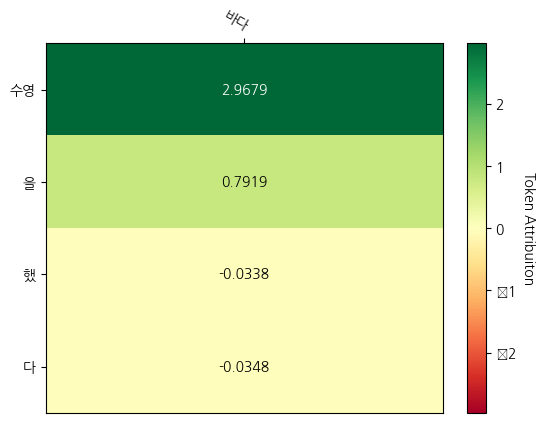

In [10]:
res1.plot_token_attr(show = True)

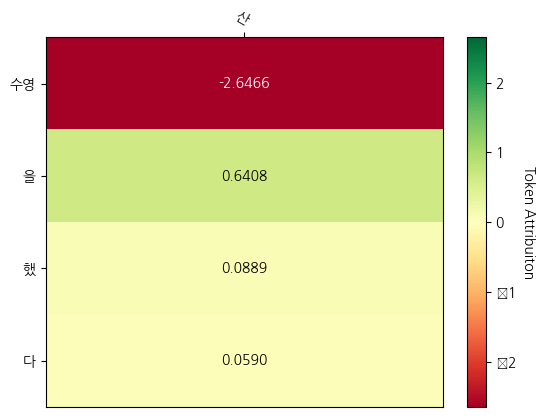

In [11]:
res2.plot_token_attr(show = True)

{'바다': 3.6911797523498535}
tensor([[ 2.9679],
        [ 0.7919],
        [-0.0338],
        [-0.0348]])
['바다']
['수영', '을', ' 했', '다']


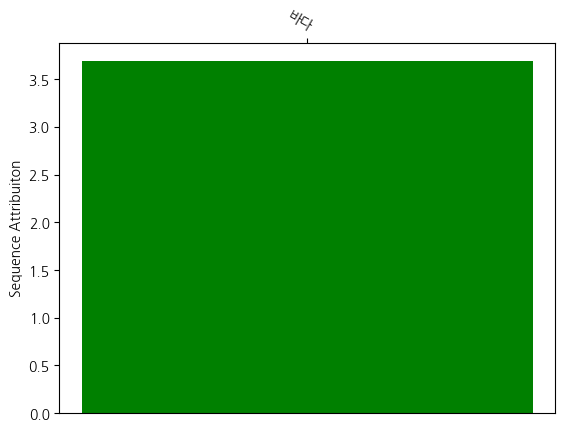

In [12]:
## Other attributes of result
print(res1.seq_attr_dict)
print(res1.token_attr)
print(res1.input_tokens)
print(res1.output_tokens)

res1.plot_seq_attr(show = True)

## Attribution with Targets

In [13]:
res1_no_baseline = calculate_attributions(
	llm_attr, tokenizer,
	"나는 {}에서",
	values = ["바다"],
	baselines = None,
	target = "수영을 했다"
)
res2_no_baseline = calculate_attributions(
	llm_attr, tokenizer,
	"나는 {}에서",
	values = ["산"],
	baselines = None,
	target = "수영을 했다"
)

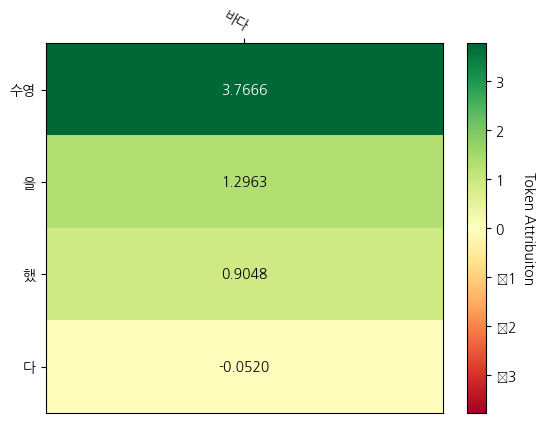

In [14]:
res1_no_baseline.plot_token_attr(show = True)

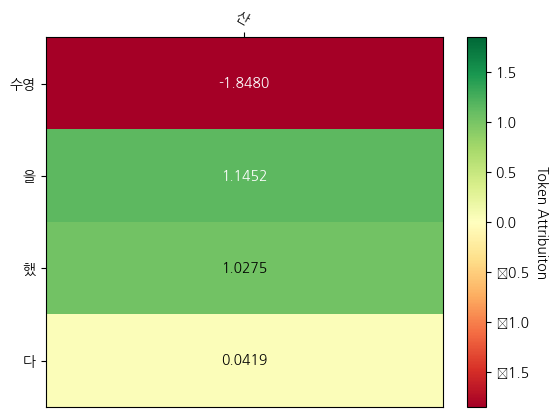

In [15]:
res2_no_baseline.plot_token_attr(show = True)

## Attribution with only inputs

In [16]:
res_only_input = calculate_attributions(
	llm_attr, tokenizer,
	"나는 {}에서",
	values = ["바다"],
	baselines = None,
	target = None
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


/Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 288 (\N{LATIN CAPITAL LETTER G WITH DOT ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 292 (\N{LATIN CAPITAL LETTER H WITH CIRCUMFLEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 314 (\N{LATIN SMALL LETTER L WITH ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 300 (\N{LATIN CAPITAL LETTER I WITH BREVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages/IPython/core

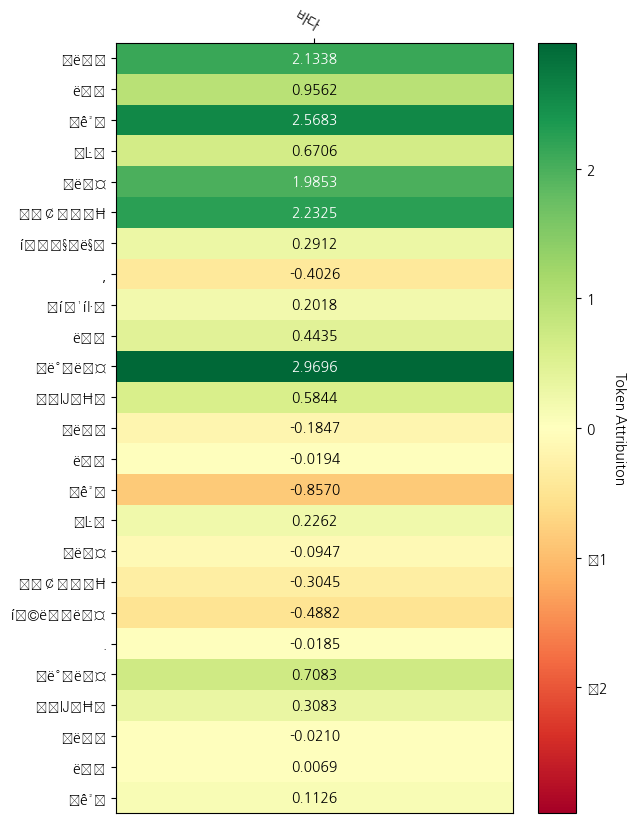

In [17]:
res_only_input.plot_token_attr(show = True)